# Protein equilibrium denaturation as a non-linear model

The equilibrium denaturation experiment of a two-state folding protein, followed
by tryptophan fluorescence, usually produces an S-shaped curve where the 
intensity of the fluorescent signal remains first stable, then drops sharply and
finally reaches a plateau as the concentration of denaturant agent (GdmCl) increases.

This behaviour can be modelled by the follow equation, which is related to a
logistic function:

$$I = I_{0} + \frac{L}{1 + 10^{m \cdot (x - x_0)}}$$

where $I_{0}$ represents the residual signal when the protein is fully unfolded,
$L$ is the total singal change between the native N and dentured D states,
$x_0$ is the concentration of denaturant at the midpoint, i.e., half-way through the transition,
and $m$ is a parameter related to the sharpness of the transition.

We can use this model to fit the equilibrium denaturation experiment data and obtain
our estimates for the protein stability, $log(K)$, and midpoint, $[\mathrm{GdmCl}]_{\frac{1}{2}}$,
directly.

In [1]:
# modules
import pandas as pd
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

## Mock dataset

In [2]:
df = pd.DataFrame({
    "GdmCl": np.array([
        0.25,
        0.50,
        0.75,
        1,
        1.5,
        1.75,
        2,
        2.5,
        2.75,
        3,
        3.5,
        4
    ], dtype=float),
    "Intensity": np.array([
        101,
        97,
        102,
        96,
        88,
        62,
        52,
        48,
        28,
        20,  # 20 or 19
        26,
        23
    ], dtype=float)
})

df.head(12)

,GdmCl,Intensity
0,0.25,101.0
1,0.50,97.0
2,0.75,102.0
3,1.00,96.0
4,1.50,88.0
5,1.75,62.0
6,2.00,52.0
7,2.50,48.0
8,2.75,28.0
9,3.00,20.0


Which gives the familiar S-shaped curve

<AxesSubplot:xlabel='GdmCl', ylabel='Intensity'>

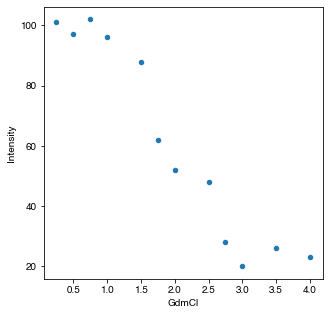

In [3]:
fig = plt.figure(figsize=(5, 5))
ax = fig.subplots(1, 1)
# ax
df.plot.scatter(
    "GdmCl",
    "Intensity",
    ax=ax
)

The implementation will be dependent of the programming language you are
using (Python, R, etc.) and the libraries found therein, but they are likely
to follow a similar scheme.

We start by defining functions that calculate the predictions
and the residuals:

In [4]:
# Model function
def logistic(beta, x):
    I0, L, m, x0 = beta
    return I0 + L / (1 + np.exp(m*(x - x0)))


# Calculate residuals
def residuals(beta, x, y):
    return y - logistic(beta, x)

Then we need to decide on some **initial values**.  As opposed to linear fit problems,
which can be solved *analytically*, non-linear fitting can
only be solved *numerically*. In practice, this entails an iterative process
where an algorithm progressively improves the fit of the model to the data,
but changing the values of the parameters. There's different algos for
different situations, one popular one being named after a guy called
Levenberg-Marquardt, two guys actually.

The `residuals` function defined above provides a way for the algorithm
to evaluate the quality of the data, it's what's sometimes called
the loss-function or the objective-function.

Once it gets going, the algoritm **minimises** the loss-function
until convergence: it stops when no further improvement
can be made by changing the parameters.

However, the computer needs to start somewhere, and that's why
the initial values are so important. If our initital values
are to far off the "true" values, we will end up with a bad fit.
This is because the algorithms are good at finding **local** solutions,
rather than global ones, so as the explore the loss-function,
they can get stuck. If we provide good initial values, closer
to the actual paramters, we will be more likely to find the optimal
fit.

Choose wisely now:

In [5]:
# beta = I0, L, m, x0
beta = [20, 80, 0.1, 3]

Luckily, we don't need to code the algorithm, we will borrow someone else's implementation:

In [6]:
lsq = least_squares(residuals, beta, args=(df.GdmCl, df.Intensity), verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.2929e+03                                    7.70e+03    
       1              5         1.6318e+03      3.66e+03       1.29e+00       2.90e+03    
       2              6         3.7326e+02      1.26e+03       2.58e+00       6.73e+02    
       3              7         2.1222e+02      1.61e+02       5.16e+00       2.93e+02    
       4              8         1.7490e+02      3.73e+01       5.90e+00       5.56e+01    
       5              9         1.7400e+02      9.02e-01       1.31e+00       1.52e+01    
       6             10         1.7395e+02      4.90e-02       2.86e-01       1.82e+00    
       7             11         1.7395e+02      2.05e-03       7.17e-02       7.69e-01    
       8             12         1.7395e+02      1.09e-04       1.24e-02       1.26e-01    
       9             13         1.7395e+02      6.01e-06       3.74e-03       3.90e-02    

The table above collects the refinements the algorithm has made over
several iterations. If you look at the `Cost` column, you can see
by how much the fit of our model improved from our initial guesses.

The solutions are given as an attribute to the `lsq` object (blablabla python jargon):

In [7]:
beta_solutions = lsq.x  # the attribute was called x because..
print(f"solutions = {beta_solutions}")

solutions = [22.82249654 80.26728698  2.57948355  1.86748911]


Now we can pass those solutions to our `logistic` model function, and compare
the model to our measurements:

Text(0, 0.5, 'Fluorescence Intensity')

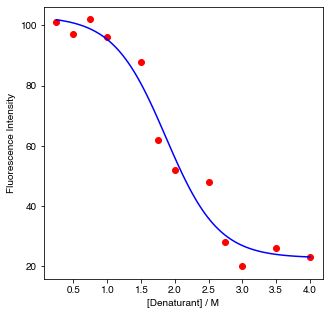

In [8]:
# Predictions
Xpred = np.linspace(df.GdmCl.min(), df.GdmCl.max(), 100)
Ypred = logistic(beta_solutions, Xpred)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.scatter(df.GdmCl, df.Intensity, marker="o", color="red")
plt.plot(Xpred, Ypred, linestyle="-", color="blue")
plt.xlabel("[Denaturant] / M")
plt.ylabel("Fluorescence Intensity")

Not bad! From the reported solutions we can directly read
the value of the midpoint as 1.9 M GdmCl.

The stability of the protein is not directly
visible in that equation, but we saw it during the derivation
of this model where, we included
$\Delta G$ as follows:

$$I = I_0 + \frac{L}{1 + 10^{\Delta G/2.3RT}}$$

where $\Delta G / 2.3 RT = - \log(K)$. That expression became 

$$I = I_0 + \frac{L}{1 + 10^{\gamma \cdot (x - x_0)/2.3RT}}$$

when we took into account the known relationship between $\Delta G$ and
denaturant concentration, such that we can identify $\gamma / 2.3RT = m$ and so
it follows that

$$m \cdot (x - x_0) = - \log(K),$$

which at [GdmCl] = 0 becomes 

$$ m(-x_0) = -\log(K)$$

In [9]:
stability = beta_solutions[3] * beta_solutions[2]
print(f"log(K) = {stability}")

log(K) = 4.817157432633504
